In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi
from utils import plot_simplices

In [2]:
SHAPE_PATH = "dataset/shapefiles/025-imperial.shp"
VOTES_PATH = "dataset/final-results/025-imperial.csv"

shapes_gdf = gpd.read_file(SHAPE_PATH)
votes_df = pd.read_csv(VOTES_PATH)

In [3]:
shapes_gdf = shapes_gdf.set_index('pct16').drop('area', axis=1)
votes_df = votes_df.set_index('pct16')[['pres_clinton', 'pres_trump']]
gdf = shapes_gdf.join(votes_df)

In [4]:
def delta(votes_clinton, votes_trump):
    sum_votes = votes_clinton + votes_trump
    if sum_votes == 0:
        return 0
    
    return abs(votes_clinton - votes_trump)/sum_votes

In [5]:
gdf = gdf[gdf['pres_clinton'] > gdf['pres_trump']]
pct_id_to_vert = {}
vert_to_pct_id = [None] * len(gdf)
vert = 0
for index, row in gdf.iterrows():
    gdf.at[index, 'delta'] = delta(row['pres_clinton'], row['pres_trump'])
    pct_id_to_vert[index] = vert
    vert_to_pct_id[vert] = index
    vert += 1

In [20]:
delta = 0.95
simplex_tree = gudhi.SimplexTree()

while delta >= 0:
    curr_complex = []
    vertices = gdf[gdf['delta'] >= delta].index.tolist()
    
    # Add 0-simplices
    for v in vertices:
        # Don't add duplicates from a complex with higher delta
        vert_index = pct_id_to_vert[v]
        duplicate = False
        for simplex, fval in simplex_tree.get_filtration():
            if len(simplex) != 1:
                continue
            if simplex[0] == vert_index:
                duplicate = True
                break
        if not duplicate:
            curr_complex.append([vert_index])
    
    # Find neighbors for each vertex
    neighbors_dict = {}
    tmp = gdf.loc[vertices, :]
    for index, row in tmp.iterrows():
        neighbors_dict[index] = tmp[tmp['geometry'].touches(row['geometry'])].index.tolist()
    
    # Add 1-simplices
    for key, neighbors in neighbors_dict.items():
        for val in neighbors:
            simplex = [pct_id_to_vert[val], pct_id_to_vert[key]]
            simplex.sort()
            # Don't add duplicate 1-simplices from the same complex
            if simplex in curr_complex:
                continue
            
            # Don't add duplicates from a complex with higher delta
            duplicate = False
            for added_simplex, fval in simplex_tree.get_filtration():
                if len(added_simplex) != 2:
                    continue
                if np.array_equal(simplex, added_simplex):
                    duplicate = True
                    break
            if not duplicate:
                curr_complex.append(simplex)

    for simplex in curr_complex:
        simplex_tree.insert(simplex, 1-delta)
   
    delta = round(delta-0.05, 2)

In [8]:
fmt = '%s -> %.2f'
for filtered_value in simplex_tree.get_filtration():
    print(fmt % tuple(filtered_value))

[0] -> 0.05
[39] -> 0.05
[48] -> 0.05
[53] -> 0.05
[54] -> 0.05
[60] -> 0.05
[53, 60] -> 0.05
[85] -> 0.05
[46] -> 0.10
[65] -> 0.10
[27] -> 0.15
[47] -> 0.15
[49] -> 0.15
[78] -> 0.15
[7] -> 0.20
[43] -> 0.20
[7, 43] -> 0.20
[44] -> 0.20
[45] -> 0.20
[44, 45] -> 0.20
[7, 46] -> 0.20
[44, 47] -> 0.20
[45, 47] -> 0.20
[43, 49] -> 0.20
[8] -> 0.25
[7, 8] -> 0.25
[9] -> 0.25
[28] -> 0.25
[7, 28] -> 0.25
[27, 28] -> 0.25
[29] -> 0.25
[28, 29] -> 0.25
[41] -> 0.25
[8, 43] -> 0.25
[8, 46] -> 0.25
[28, 46] -> 0.25
[29, 46] -> 0.25
[57] -> 0.25
[8, 60] -> 0.25
[76] -> 0.25
[49, 76] -> 0.25
[77] -> 0.25
[76, 77] -> 0.25
[15] -> 0.30
[30] -> 0.30
[32] -> 0.30
[34] -> 0.30
[42] -> 0.30
[7, 42] -> 0.30
[15, 42] -> 0.30
[42, 43] -> 0.30
[15, 44] -> 0.30
[15, 45] -> 0.30
[42, 49] -> 0.30
[51] -> 0.30
[7, 51] -> 0.30
[15, 51] -> 0.30
[28, 51] -> 0.30
[42, 51] -> 0.30
[44, 51] -> 0.30
[47, 51] -> 0.30
[15, 53] -> 0.30
[15, 77] -> 0.30
[42, 77] -> 0.30
[30, 78] -> 0.30
[12] -> 0.35
[8, 12] -> 0.35
[26]

In [9]:
gdf['centroid'] = gdf.to_crs('epsg:3785').centroid.to_crs(gdf.crs)
points = [[x, y] for x, y in zip(gdf['centroid'].values.x, gdf['centroid'].values.y)]

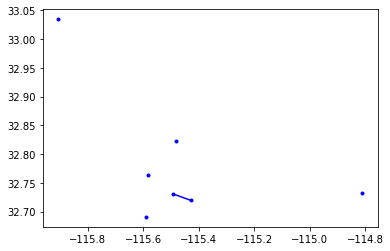

In [13]:
plot_simplices(points, simplex_tree, 0.06)

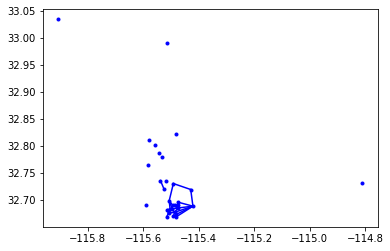

In [16]:
plot_simplices(points, simplex_tree, 0.31)